## Training

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

try:
  import tf_agents
except ImportError:
  %pip install tf-agents
  %pip install tf-keras

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"gpus: {gpus}")

gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import random

seed = 0
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

np.set_printoptions(precision=6, suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.networks import encoding_network
from tf_agents.specs import tensor_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.policies import policy_saver

from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS, collate_results
from trading_env import CryptoTradingEnvironment
from observers import ProgressObserver, MetricsObserver

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Data and Model Paths
DATA_FILEPATH = 'data/ohlcv.csv.gz'
POLICY_SAVE_PATH = 'policy'

# Model Hyperparameters
MAX_TRAIN_STEPS = 3000
TRAIN_OFFSET = 0
MAX_EVAL_STEPS = 1000
ALPHA = 2.0 # LinUCB exploration parameter - default 1.0
GAMMA = 0.9 # LinUCB forgetting parameter - default 1.0
LEARNING_RATE = 0.001
FC_LAYER_PARAMS = (52, 26)
TEST_SIZE = 0.2
SEED_FUND = 100.0
MAX_BUY_PRICE = 25.0
MAX_SELL_PRICE = 50.0
TRADE_FEE = 0.0005
INVALID_ACTION_PENALTY = -0.05

TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']
TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd_signal', 'macd_hist', 'macd_hist_prev', 'bb_percent_b', 'bb_bandwidth']
TECHNICAL_FEATURES = ['price_change', 'volume_change', 'rsi', 'macd_signal', 'macd_hist']

# Load Data
df = pd.read_csv(DATA_FILEPATH, compression='gzip', parse_dates=['timestamp']) #.set_index('timestamp')
all_data = preprocess_data(df)
observation_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=SYMBOLS, 
    features=TECHNICAL_FEATURES
)

train_observation_df, test_observation_df = train_test_split(
    observation_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

train_prices_df, test_prices_df = train_test_split(
    prices_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

scaler = StandardScaler()
train_observation_scaled_df = pd.DataFrame(scaler.fit_transform(train_observation_df), columns=train_observation_df.columns, index=train_observation_df.index)
test_observation_scaled_df = pd.DataFrame(scaler.transform(test_observation_df), columns=train_observation_df.columns, index=test_observation_df.index)


print(f"all_data: {all_data.shape}")
print(f"observation training data: {train_observation_scaled_df.shape}")
print(f"price training data: {train_prices_df.shape}")
print(f"observation testing data: {test_observation_scaled_df.shape}")
print(f"price testing data: {test_prices_df.shape}")

display(train_observation_scaled_df[TRAIN_OFFSET:].head(3))
display(train_prices_df[TRAIN_OFFSET:].head(3))

all_data: (111560, 16)
observation training data: (17849, 25)
price training data: (17849, 5)
observation testing data: (4463, 25)
price testing data: (4463, 5)


,BTC_price_change,BTC_volume_change,BTC_rsi,BTC_macd_signal,BTC_macd_hist,DOGE_price_change,DOGE_volume_change,DOGE_rsi,DOGE_macd_signal,DOGE_macd_hist,...,ETH_price_change,ETH_volume_change,ETH_rsi,ETH_macd_signal,ETH_macd_hist,SOL_price_change,SOL_volume_change,SOL_rsi,SOL_macd_signal,SOL_macd_hist
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 19:00:00,0.1105,-0.0075,0.2817,-0.0763,0.0640,0.0003,-0.0075,-1.3453,-0.0565,0.1529,...,0.1078,-0.0075,-0.3148,0.0043,0.1182,-0.3214,-0.0075,0.9613,-0.0812,0.0513
2023-01-01 20:00:00,-0.0049,-0.0075,0.3061,-0.0707,0.0686,0.1283,-0.0075,-1.1703,-0.0432,0.1777,...,-0.0651,-0.0075,-0.3923,0.0136,0.1185,-0.0214,-0.0075,0.9613,-0.0770,0.0521
2023-01-01 21:00:00,0.0038,-0.0075,0.3629,-0.0651,0.0684,-0.1275,-0.0075,-1.2632,-0.0301,0.1748,...,0.1900,-0.0075,-0.0448,0.0237,0.1277,0.0789,-0.0075,0.9613,-0.0728,0.0521


symbol,BTC,DOGE,XRP,ETH,SOL
timestamp,,,,,
2023-01-01 19:00:00,16603.0800,0.0703,0.3390,1201.7800,9.9700
2023-01-01 20:00:00,16604.5100,0.0704,0.3387,1201.4000,9.9700
2023-01-01 21:00:00,16606.6800,0.0703,0.3386,1202.8500,9.9800


In [4]:
# Setup Environment
crypto_env = CryptoTradingEnvironment(
    observation_df=train_observation_scaled_df[TRAIN_OFFSET:],
    prices_df=train_prices_df[TRAIN_OFFSET:],
    symbols=SYMBOLS,
    seed_fund=SEED_FUND,
    max_buy_price=MAX_BUY_PRICE,
    max_sell_price=MAX_SELL_PRICE,
    trade_fee=TRADE_FEE,
    invalid_action_penalty=INVALID_ACTION_PENALTY,
)

tf_env = tf_py_environment.TFPyEnvironment(crypto_env)

obs_spec_size = tf_env.observation_spec().shape[0]


encoding_network = encoding_network.EncodingNetwork(
    input_tensor_spec=tf_env.observation_spec(),
    fc_layer_params=(obs_spec_size * 2, obs_spec_size),
    # The final, output layer of this network will have obs_spec_size units.
    # This is handled internally by the class.
    # The output of this network is the "context" for the LinUCB algorithm.
)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Setup Agent
agent = neural_linucb_agent.NeuralLinUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    encoding_network=encoding_network,
    encoding_dim=obs_spec_size,
    encoding_network_num_train_steps=1,
    optimizer=optimizer,
    alpha=ALPHA,
    gamma=GAMMA,
    dtype=tf.float32
)

def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)


num_train_steps = min(len(train_observation_scaled_df) - 1, MAX_TRAIN_STEPS)

metrics_observer = MetricsObserver(crypto_env)
progress_observer = ProgressObserver(num_train_steps)

# 5. Setup Driver
driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=num_train_steps,
    observers=[
        train_step,
        metrics_observer,
        progress_observer,
    ]
)

print(f"Starting training for {num_train_steps} steps...")
driver.run()
print("Training finished.")

# Save Policy
print(f"Saving the trained policy to: {POLICY_SAVE_PATH}")
saver = policy_saver.PolicySaver(agent.policy)
saver.save(POLICY_SAVE_PATH)
print("Policy saved successfully.")

Starting training for 3000 steps...


I0000 00:00:1753728861.421685    1655 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2975/3000

3000/3000Training finished.
Saving the trained policy to: policy


INFO:tensorflow:Assets written to: policy/assets


INFO:tensorflow:Assets written to: policy/assets


Policy saved successfully.


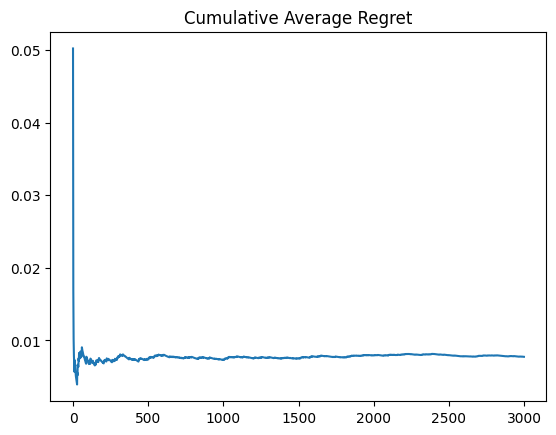

In [5]:
cumulative_avg_reward, cumulative_avg_optimal_reward, cumulative_avg_regret = metrics_observer.cum_averages()

plt.plot(cumulative_avg_regret)
plt.title('Cumulative Average Regret')
plt.show()

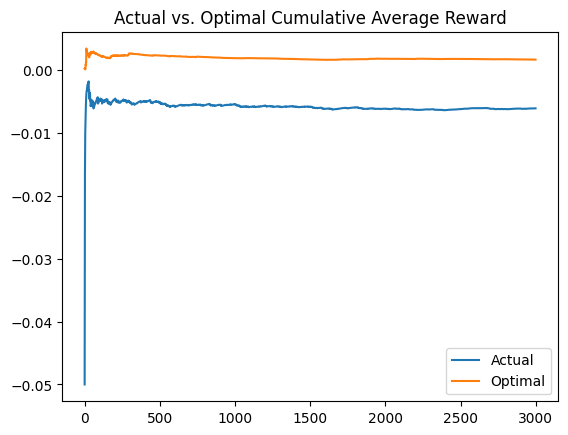

In [6]:
plt.plot(cumulative_avg_reward, label='Actual')
plt.plot(cumulative_avg_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Average Reward')
plt.legend()
plt.show()

Initial Portfolio Value: $100.00
Final Portfolio Value:   $122.95
Total Return on Test Set: 22.95%


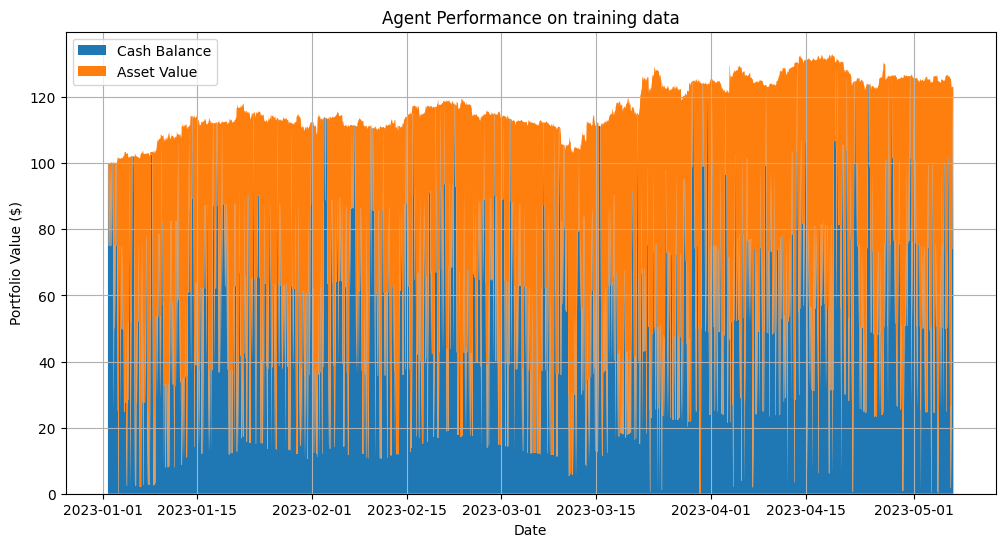

In [7]:
balance_history = metrics_observer.balance_history
asset_value_history = metrics_observer.asset_value_history
portfolio_value_history = metrics_observer.portfolio_value_history
initial_portfolio_value = portfolio_value_history[0]
final_portfolio_value = portfolio_value_history[-1]
total_return_pct = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

print(f"Initial Portfolio Value: ${initial_portfolio_value:,.2f}")
print(f"Final Portfolio Value:   ${final_portfolio_value:,.2f}")
print(f"Total Return on Test Set: {total_return_pct:.2f}%")

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.stackplot(train_prices_df.index[:len(balance_history)],[balance_history, asset_value_history], labels=['Cash Balance','Asset Value'])
plt.legend(loc='upper left')
plt.title('Agent Performance on training data')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

<Axes: ylabel='Trade Type'>

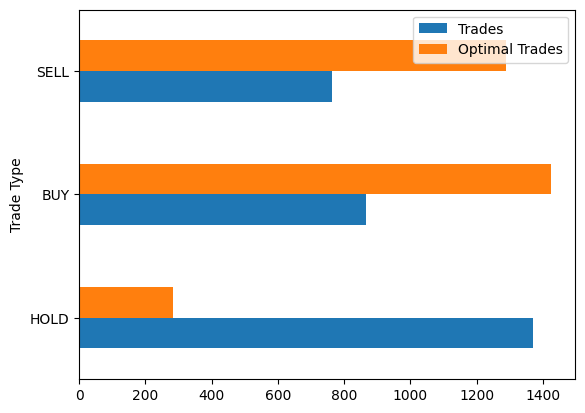

In [8]:
trade_history = metrics_observer.trade_history
optimal_trade_history = metrics_observer.optimal_trade_history

trade_history_df = pd.DataFrame(trade_history, columns=['Action', 'Symbol IDX', 'Symbol', 'Trade Type', 'Valid', 'Num Assets Traded', 'Trade Amount', 'Balance', 'Reward'])
optimal_trade_history_df = pd.DataFrame(optimal_trade_history, columns=['Action', 'Symbol IDX', 'Symbol', 'Trade Type', 'Valid', 'Num Assets Traded', 'Trade Amount', 'Balance', 'Reward'])
trade_types = trade_history_df['Trade Type'].astype(str).value_counts().rename('Trades')
optimal_trade_types = optimal_trade_history_df['Trade Type'].astype(str).value_counts().rename('Optimal Trades')

pd.concat([trade_types, optimal_trade_types], axis=1).plot(kind='barh')

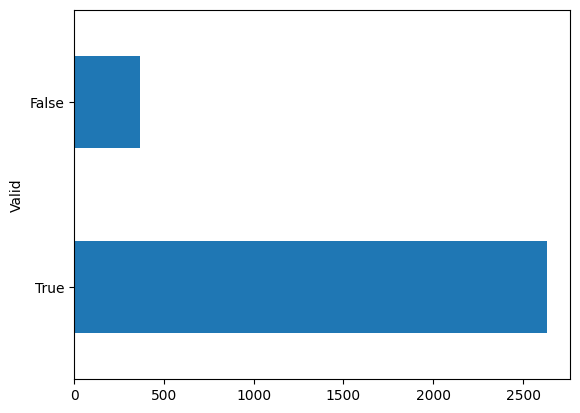

In [9]:
valid_actions = trade_history_df['Valid'].value_counts()

valid_actions.plot(kind='barh')
plt.show()

valid_action_rate = valid_actions[True] / len(trade_history)

## Evaluation

In [10]:
num_eval_steps = min(len(test_observation_scaled_df) - 1, MAX_EVAL_STEPS)

eval_env = CryptoTradingEnvironment(
    observation_df=test_observation_scaled_df,
    prices_df=test_prices_df,
    symbols=SYMBOLS,
    seed_fund=SEED_FUND,
    max_buy_price=MAX_BUY_PRICE,
    max_sell_price=MAX_SELL_PRICE,
    trade_fee=TRADE_FEE,
    invalid_action_penalty=INVALID_ACTION_PENALTY,
)

tf_eval_env = tf_py_environment.TFPyEnvironment(eval_env)

eval_metrics_observer = MetricsObserver(eval_env)
eval_progress_observer = ProgressObserver(num_eval_steps)

eval_driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_eval_env,
    policy=agent.policy,
    num_steps=num_eval_steps,
    observers=[
        eval_metrics_observer,
        eval_progress_observer
    ]
)

print(f"Starting evaluating for {num_eval_steps} steps...")
eval_driver.run()
print("Evaluation finished.")

Starting evaluating for 1000 steps...
1000/1000Evaluation finished.


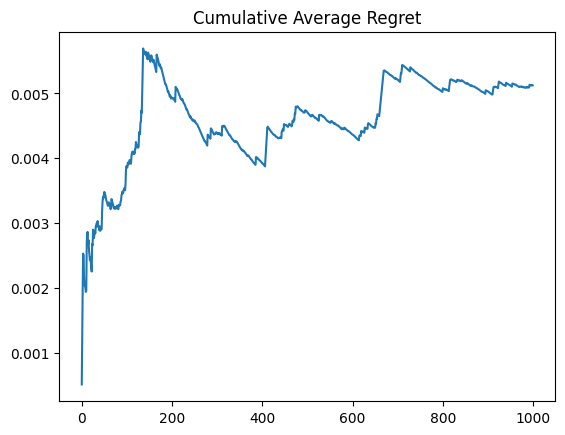

In [11]:
eval_cumulative_avg_reward, eval_cumulative_avg_optimal_reward, eval_cumulative_avg_regret = eval_metrics_observer.cum_averages()

plt.plot(eval_cumulative_avg_regret)
plt.title('Cumulative Average Regret')
plt.show()

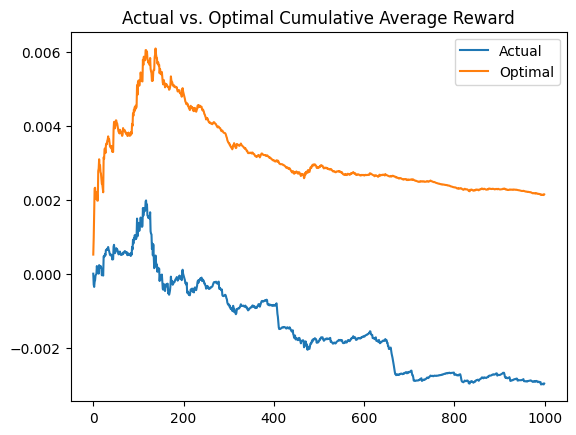

In [12]:
plt.plot(eval_cumulative_avg_reward, label='Actual')
plt.plot(eval_cumulative_avg_optimal_reward, label='Optimal')
plt.title('Actual vs. Optimal Cumulative Average Reward')
plt.legend()
plt.show()

Initial Portfolio Value: $100.00
Final Portfolio Value:   $64.02
Total Return on Test Set: -35.98%


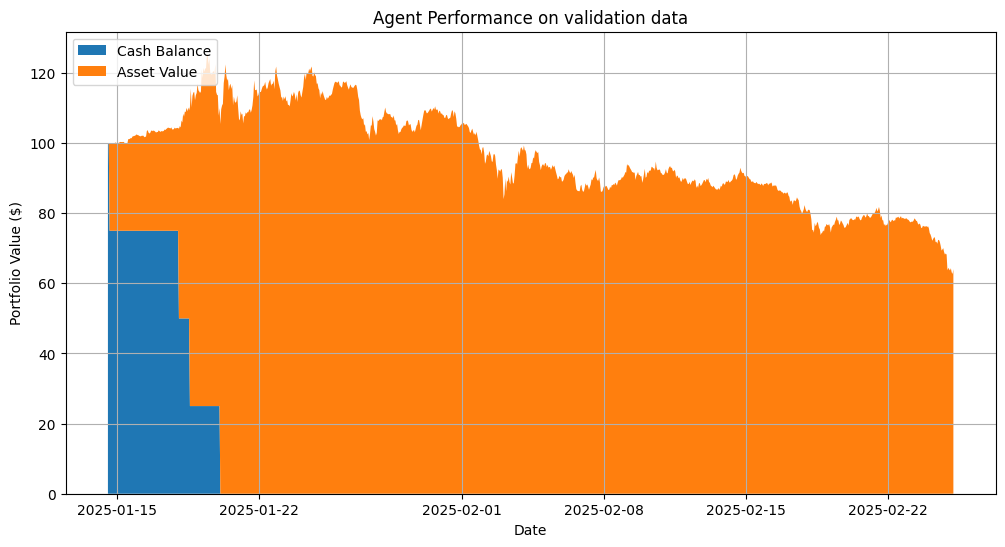

In [13]:
# 5. Report and Plot the Results
eval_balance_history = eval_metrics_observer.balance_history
eval_asset_value_history = eval_metrics_observer.asset_value_history
eval_portfolio_value_history = eval_metrics_observer.portfolio_value_history
eval_initial_portfolio_value = eval_balance_history[0]
eval_final_portfolio_value = eval_portfolio_value_history[-1]
eval_total_return_pct = ((eval_final_portfolio_value - eval_initial_portfolio_value) / eval_initial_portfolio_value) * 100

print(f"Initial Portfolio Value: ${eval_initial_portfolio_value:,.2f}")
print(f"Final Portfolio Value:   ${eval_final_portfolio_value:,.2f}")
print(f"Total Return on Test Set: {eval_total_return_pct:.2f}%")

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.stackplot(test_prices_df.index[:len(eval_balance_history)],[eval_balance_history, eval_asset_value_history], labels=['Cash Balance','Asset Value'])
plt.legend(loc='upper left')
plt.title('Agent Performance on validation data')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

<Axes: ylabel='Trade Type'>

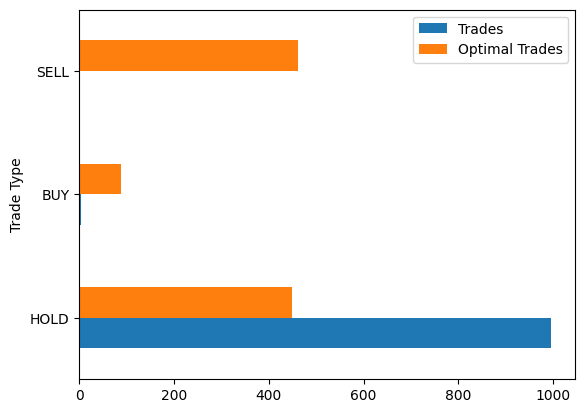

In [14]:
eval_trade_history = eval_metrics_observer.trade_history
eval_optimal_trade_history = eval_metrics_observer.optimal_trade_history

eval_trade_history_df = pd.DataFrame(eval_trade_history, columns=['Action', 'Symbol IDX', 'Symbol', 'Trade Type', 'Valid', 'Num Assets Traded', 'Trade Amount', 'Balance', 'Reward'])
eval_optimal_trade_history_df = pd.DataFrame(eval_optimal_trade_history, columns=['Action', 'Symbol IDX', 'Symbol', 'Trade Type', 'Valid', 'Num Assets Traded', 'Trade Amount', 'Balance', 'Reward'])
eval_trade_types = eval_trade_history_df['Trade Type'].astype(str).value_counts().rename('Trades')
eval_optimal_trade_types = eval_optimal_trade_history_df['Trade Type'].astype(str).value_counts().rename('Optimal Trades')

pd.concat([eval_trade_types, eval_optimal_trade_types], axis=1).plot(kind='barh')

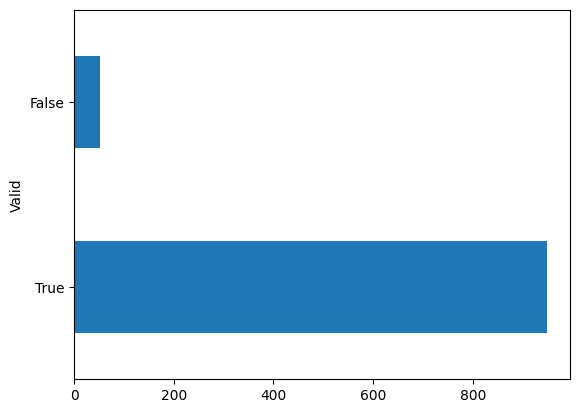

In [15]:
eval_valid_actions = eval_trade_history_df['Valid'].value_counts()

eval_valid_actions.plot(kind='barh')
plt.show()

eval_valid_action_rate = eval_valid_actions[True] / len(eval_trade_history)

In [16]:
test_optimal_actions = trade_history[:, 0] == optimal_trade_history[:, 0]
eval_optimal_actions = eval_trade_history[:, 0] == eval_optimal_trade_history[:, 0]

test_optimal_trade_rate = test_optimal_actions.sum() / len(test_optimal_actions)
eval_optimal_trade_rate = eval_optimal_actions.sum() / len(eval_optimal_actions)

results_df = collate_results(
    agent.__class__.__name__,
    num_train_steps,
    num_eval_steps,
    ALPHA,
    GAMMA,
    np.nan,
    MAX_BUY_PRICE,
    MAX_SELL_PRICE,
    TRADE_FEE,
    INVALID_ACTION_PENALTY,
    TECHNICAL_FEATURES,
    np.float32(total_return_pct).round(2),
    np.float32(eval_total_return_pct).round(2),
    valid_action_rate,
    eval_valid_action_rate,
    test_optimal_trade_rate,
    eval_optimal_trade_rate,
)

results_df.to_csv('./results.csv', mode='a', header=False, index=False)

In [17]:
all_results_df = pd.read_csv('./results.csv', parse_dates=['timestamp'])
all_results_df

,timestamp,agent,train_steps,eval_steps,alpha,gamma,learming_rate,max_buy_price,max_sell_price,trade_fee,invalid_action_penalty,technical_features,num_technical_features,test_return,eval_return,test_valid_action_rate,eval_valid_action_rate,test_optimal_trade_rate,eval_optimal_trade_rate
0,2025-07-28 18:51:23,LinearUCBAgent,2000,1000,1.0000,0.9500,NaN,25.0000,50.0000,0.0005,-0.0050,price_change|volume_change|rsi|macd_signal|mac...,5,16.1100,10.8800,0.8115,0.3780,0.0820,0.0300
1,2025-07-28 18:51:58,NeuralLinUCBAgent,2000,500,1.0000,1.0000,NaN,25.0000,50.0000,0.0005,-0.0005,price_change|volume_change|rsi|macd_signal|mac...,5,31.6300,-10.2700,0.7680,0.5120,0.0820,0.0620
2,2025-07-28 19:08:23.566518,NeuralLinUCBAgent,3000,1000,2.0000,0.9000,NaN,25.0000,50.0000,0.0005,-0.0500,price_change|volume_change|rsi|macd_signal|mac...,5,22.9500,-35.9800,0.8770,0.9480,0.0860,0.0010
